In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Math


In [2]:
from keras.datasets import fashion_mnist


# Про dataset `fashion-mnist`

Fashion-MNIST — це набір зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад являє собою зображення в градаціях сірого 28x28, пов'язане з міткою з 10 класів:

| Мітка | Опис        | Переклад         |
|-------|-------------|------------------|
| 0     | T-shirt/top | Футболка/сорочка |
| 1     | Trouser     | Штани            |
| 2     | Pullover    | Светр            |
| 3     | Dress       | Плаття           |
| 4     | Coat        | Пальто           |
| 5     | Sandal      | Сандалі          |
| 6     | Shirt       | Сорочка          |
| 7     | Sneaker     | Кросовки         |
| 8     | Bag         | Сумка            |
| 9     | Ankle boot  | Чоботи           |

# Константи

In [3]:
class_labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
input_shape = (28, 28, 1)
num_classes = 10


# Підготовка навчального та тестового наборів

In [4]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255., x_test / 255.


# Огляд даних

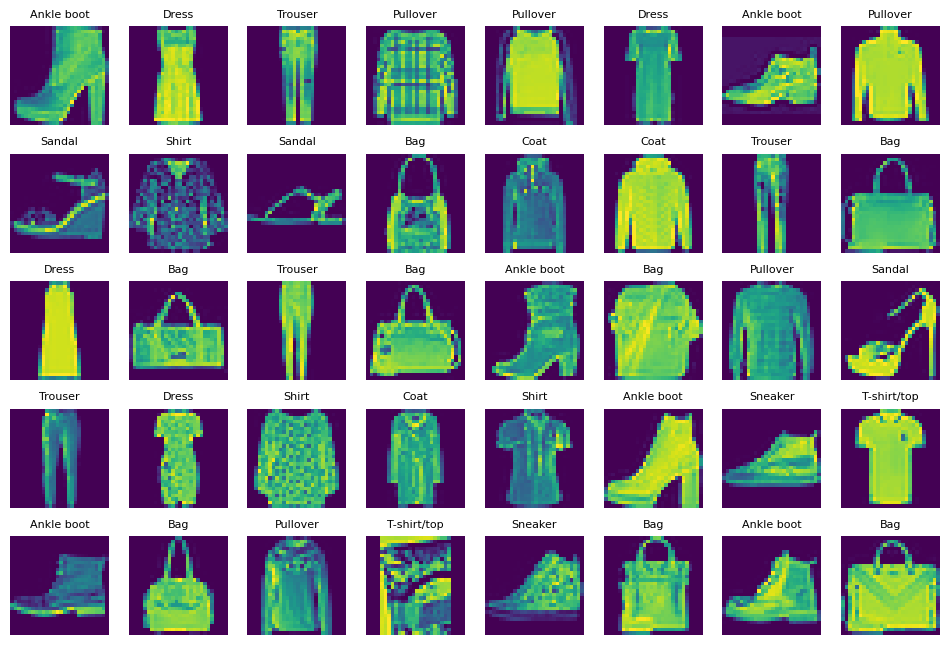

In [5]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(12, 8))

for i, sample_index in enumerate(np.random.randint(1, x_test.shape[0], number_of_images)):
    test_image = x_test[sample_index].reshape(1, -1)
    test_item = y_test[sample_index]
    ax[i//8, i % 8].imshow(test_image[0].reshape((28, 28)))
    ax[i//8, i % 8].axis('off')
    ax[i//8, i %
        8].set_title(f"{class_labels.get(test_item)}", fontsize=8)
plt.show()


# Побудова архітектури нейронної мережі (моделі)

1. [Фуннкції активації](https://keras.io/api/layers/activations/)
2. [Оптимізатори](https://keras.io/api/optimizers/)
3. [Функції втрат](https://keras.io/api/losses/)
4. [Метрики](https://keras.io/api/metrics/)

## Функції активації, переваги і недоліки

<table>
<tr>
<th>
Функція активації
</th>

<th>
Плюси
</th>

<th>
Мінуси
</th>
</tr>

<tr>
<td>
<a href="https://keras.io/api/layers/activations/#relu-function">linear</a>
</td>

<td>

- Менше часу на обчислення
</td>

<td>

- Нефіксований діапазон значень функції - [-∞,+∞].
</td>
</tr>


<tr>
<td>
<a = href="https://keras.io/api/layers/activations/#sigmoid-function">Sigmoid</a>
</td>

<td>

- У діапазоні значень сигналу від -2.5 до 2.5 значення активації змінюються дуже швидко
- Фіксований діапазон значень функції - [0,1].

</td>

<td>

- Затухають градієнти
</td>
</tr>

<tr>
<td>
<a href="https://keras.io/api/layers/activations/#tanh-function">tanh</a>
</td>

<td>

- У діапазоні значень сигналу від -2.5 до 2.5 значення активації змінюються дуже швидко
- Фіксований діапазон значень функції - [-1,1].
</td>

<td>

- Затухають градієнти 
</td>
</tr>

<tr>
<td>
<a href="https://keras.io/api/layers/activations/#relu-function">ReLU</a>
</td>
<td>

- Менше часу на обчислення
- Можна зробити мережу з меншим числом шарів
- Немає проблеми затухаючих градієнтів  
</td>

<td>

- Нульові градієнти у сигналів, які менші за 0
- Нефіксований діапазон значень функції
</td>
</tr>

<tr>
<td>
Leaky ReLU
</td>
<td>

- Немає проблеми нульових градієнтів
</td>
<td>

- Потрібно підбирати значення alpha
- Нефіксований діапазон значень функції
</td>
</tr>

<tr>
<td>
<a href="https://keras.io/api/layers/activations/#elu-function">ELU</a>
</td>

<td>

- Немає проблеми нульових градієнтів
- Є негативні виходи, що допомагає нейронці направляти ваги в потрібний напрямок
</td>

<td>

- Більше часу на обчислення
- Нефіксований діапазон значень функції
- потрібно підбирати значення alpha
</td>

</tr>

</table>


Побудуємо графіки функцій активації та їх градієнти (в даному випадку для функції однієї змінної - це поосто перша похідна). Причому зробимо це виключно за допомогою `TensorFlow`

c:\Users\Andriy\anaconda3\envs\MYDATA\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


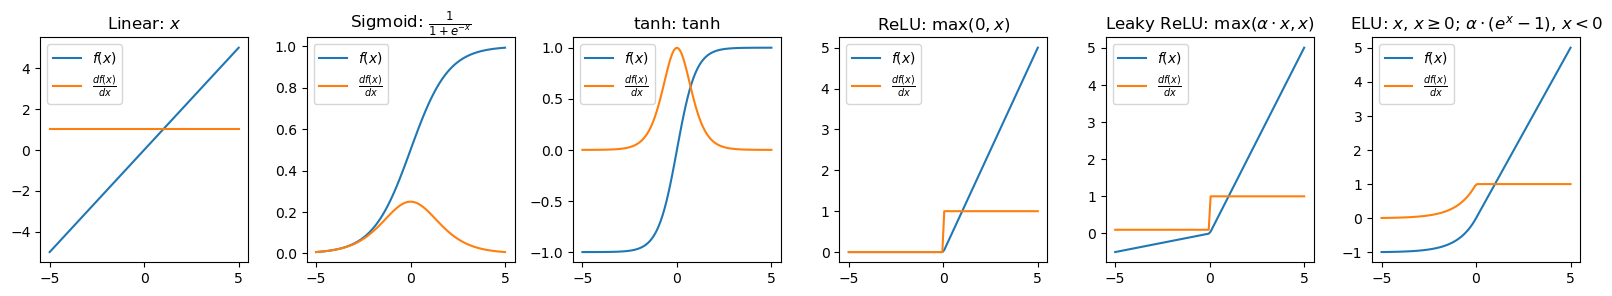

In [6]:
from tensorflow.keras.activations import linear, sigmoid, tanh, relu
from tensorflow.keras.layers import LeakyReLU, ELU

x = np.linspace(-5, 5, 100)
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

activation_functions = [linear, sigmoid, tanh, relu, LeakyReLU(alpha=0.1), ELU(alpha=1.0)]
activation_names = ['Linear', 'Sigmoid', 'tanh', 'ReLU', 'Leaky ReLU', 'ELU']
analitic = [r'$x$', r'$\frac{1}{1 + e^{-x}}$', r'$\tanh$', r'$\max(0, x)$', r'$\max(\alpha\cdot x, x)$', r'$x$, $x \geq 0$; $\alpha\cdot(e^x - 1)$, $x < 0$']


plt.figure(figsize=(16, 16))

for i in range(len(activation_functions)):
    activation_name = activation_names[i]

    plt.subplot(6, 6, i + 1)
    plt.plot(x, activation_functions[i](x_tensor).numpy(), label=r'$f(x)$')
    plt.title(f'{activation_name}: {analitic[i]}')

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y = activation_functions[i](x_tensor)
    derivative = tape.gradient(y, x_tensor).numpy()
    plt.plot(x, derivative, label=r'$\frac{df(x)}{dx}$')
    plt.legend()

plt.tight_layout()
plt.show()


## Деякі типи оптимізаторів

<table>
<tr>
<th>
Оптимізатори
</th>

<th>
Плюси
</th>

<th>
Мінуси
</th>
</tr>

<tr>
<td>
Gradient Descent
</td>

<td>

- Легко реалізувати
</td>

<td>

- Одна ітерація триває довго
- Вимогливий до пам'яті
</td>
</tr>


<tr>
<td>
Stochastic Gradient Descent

</td>

<td>

- Потребує менше пам'яті
- Можна використовувати великі датасети
- Випадковість може допомогти перестрибнути локальні мінімуми

</td>

<td>

- Часті оновлення ваг можуть вносить шум
- Випадковість може відвести не туди

</td>
</tr>

<tr>
<td>
SGD + Momentum

</td>

<td>

- Імпульс згладжує збіжність
</td>

<td>

- Додатковий параметр

</td>
</tr>

<tr>
<td>
AdaGrad
</td>

<td>

- Адаптивна зміна швидкості навчання
    
</td>

<td>

- Швидкість навчання може стати занадто маленькою
</td>
</tr>

<tr>
<td>
RMSProp
</td>

<td>

- Адаптивна зміна швидкості навчання

</td>

<td>

- Може бути повільна збіжність
</td>
</tr>

<tr>
<td>
Adam
</td>

<td>

- Адаптивна зміна швидкості навчання
- Імпульс згладжує сходження
</td>

<td>

- Додаткові параметри
</td>
</tr>

</table>

In [7]:
# Побудова архітектури моделі
keras.utils.set_random_seed(42)

def build_model(learning_rate, l2_parameter):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(128, activation='relu',
        kernel_regularizer=regularizers.l2(l2_parameter)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='relu',
        kernel_regularizer=regularizers.l2(l2_parameter)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  )
    return model


# Гіперпараметри



In [8]:
epochs = 50
steps_per_epoch = 1_2000
batch_size = 1 * 64
l2_parameter = 1e-3
learning_rate = 1e-4



# Створення моделі

In [9]:
model = build_model(learning_rate, l2_parameter)
model.summary()


c:\Users\Andriy\anaconda3\envs\MYDATA\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

# Навчання моделі

In [10]:
# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(256).prefetch(1)


# Навчання моделі
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test)
)

# Оцінка моделі на тестовому наборі даних
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'\nТочність на тестовому наборі: {test_accuracy:.2f}')


Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5677 - loss: 1.5920 - val_accuracy: 0.7944 - val_loss: 0.8621
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7824 - loss: 0.8937 - val_accuracy: 0.8203 - val_loss: 0.7562
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8147 - loss: 0.7766 - val_accuracy: 0.8335 - val_loss: 0.6982
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8295 - loss: 0.7171 - val_accuracy: 0.8402 - val_loss: 0.6615
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8386 - loss: 0.6747 - val_accuracy: 0.8471 - val_loss: 0.6311
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8455 - loss: 0.6411 - val_accuracy: 0.8515 - val_loss: 0.6090
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8481 - loss: 0.6184 - val_accuracy: 0.8550 - val_loss: 0.5902
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8535 - loss: 0.5928 - val_accuracy: 0.

## Візуалізація кривих навчання

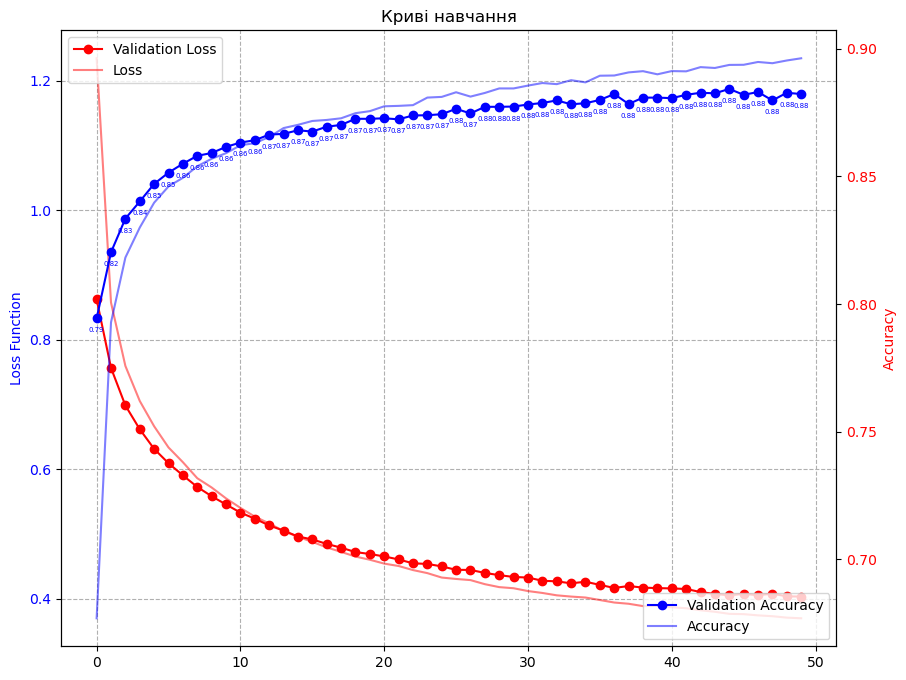

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='r')
ax1.plot(history.history['loss'], label='Loss', color='r', alpha=0.5)
ax1.set_ylabel('Loss Function', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy',  marker='o', color='b')
ax2.plot(history.history['accuracy'], label='Accuracy', color='b', alpha=0.5)
                         
for i, acc in enumerate(history.history['val_accuracy']):
    ax2.annotate(f'{acc:.2f}', (i, acc), textcoords="offset points", xytext=(0, -10), ha='center', c='b', fontsize=5)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.grid(True, linestyle='--') 

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title('Криві навчання')

plt.show()

На кривих спостегрігається деяке перенавчання. Якщо збільшити параметр $L_2$-регуляризації, то ефекту перенавчання можна буде позбутись, але точність впаде.

# Перевірка результатів

In [12]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


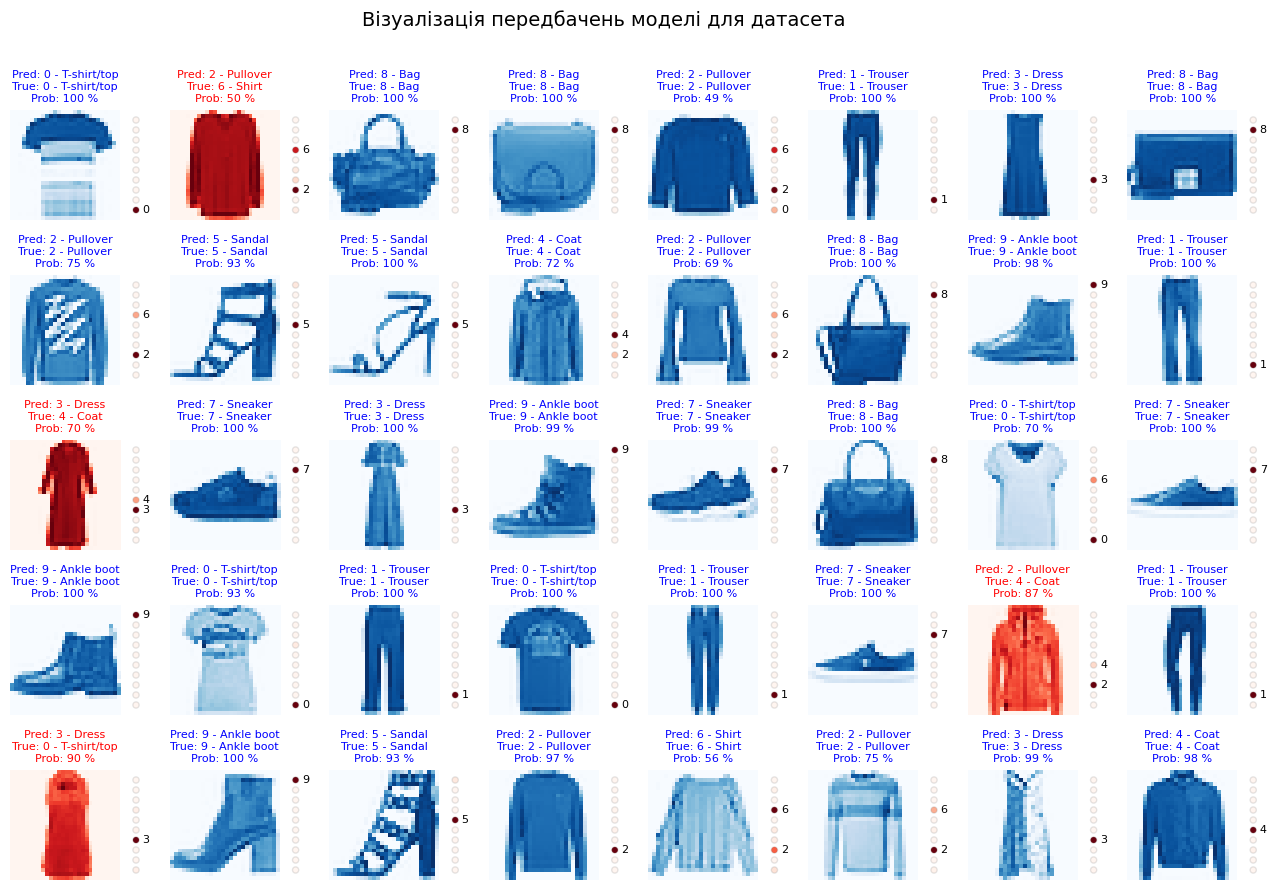

In [13]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(16, 10))
f.subplots_adjust(hspace=0.5, wspace=0.3)

f.suptitle("Візуалізація передбачень моделі для датасета", fontsize=14)


for axes_index, sample_index in enumerate(np.random.choice(10000, number_of_images)):
    prob = predictions[sample_index]
    img, true_label = x_test[sample_index], y_test[sample_index]
    predicted_label = np.argmax(prob)
    if predicted_label == true_label:
        color = 'blue'
        cmap = 'Blues'
    else:
        color = 'red'
        cmap = 'Reds'

    ax[axes_index//8, axes_index % 8].imshow(img, cmap=cmap)
    ax[axes_index//8, axes_index % 8].axis('off')
    ax[axes_index//8, axes_index %
        8].set_title(f"Pred: {predicted_label} - {class_labels.get(predicted_label)}\nTrue: {true_label} - {class_labels.get(true_label)}\nProb: {prob.max()*100:.0f} %", fontsize=8, color=color)
    
    inset_ax = f.add_axes([ax[axes_index//8, axes_index % 8].get_position().x1, ax[axes_index//8, axes_index % 8].get_position().y0, 0.02, ax[axes_index//8, axes_index % 8].get_position().height])

    classes = np.arange(len(class_labels))
    inset_ax.scatter(np.ones(10)*0.5, 
                     classes, 
                     s=20, 
                     c=prob, 
                     cmap='Reds', 
                     marker='o',
                     edgecolor=(0.5, 0.5, 0.5, 0.2),
                     linewidths=1,
                     )
    inset_ax.set_xlim(0, 1)
    inset_ax.set_ylim(-1, 10)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.axis('off')
    for i, p in enumerate(prob):
        if p > 0.1:
            inset_ax.text(0.7, i, f'{i}', fontsize=8, verticalalignment='center')

plt.show()

На візуалізації представлені зображення із тестової вибірки. В синіх тонах - розпізнані правильно, в червоних - неправильно. Праворуч наведена шкала (фактично це нейрони вихідного шару), де колір пропорційний "ймовірності" розпізнавання, також праворуч наведені мітки класів (номер нейрона), якщо їх ймовірність більше 10 %, щоб можна побачити принаймні, де наша модель мала "сумніви", і врешті решт якому класу вона давала перевагу. Можливо, це в подальших дослідженнях натякне на спосіб покращення точності.

Крім того ця візуалізація зайвий раз поазує визначену точність $\approx 0.89$. В середньому 4 з 40 зображень неправильно розпізнані.

# Висновки

В експериментах я пробував додавати певне число нейронних шарів, змінював активаційні функції та оптимізатори, а також інші гіперпараметри. Однак я домігся точності лише $90$ % уже для простої архітектури нейронної мережі і стандартного оптимізатора `Adam`. Ускладнення архітектури, використання інших оптимізаторів та гіерпараметрів не допомагали перевищували цю точність, і більше того навіть подовжували процес навчання. 

1. Регуляризація: збільшення параметру регуляризації зменшує перенавчання, що добре видно на графіку залежностей функції втрат від номеру епохи для тренувальної та тестової вибірок, при підвищенні цього параметру криві майже накладаються одна на одну, однак при цьому точність погіршується.
2. Використання алгоритму `Dropout` дещо покращує точність за рахунок зменшення "спеціалізації нейронів", але не суттєво.

На жаль, використання нейоронної мережі на основі повнозв'язних шарів не дає можливості (принаймні я не знайшов кращих параметрів) які б давали точність $ > 91$ %




# Посилання

1. [Базовая классификация: Классифицировать изображения одежд](https://www.tensorflow.org/tutorials/keras/classification?hl=ru)